In [ ]:
import pandas as pd
import numpy as np
import oracledb
from sqlalchemy import create_engine
import os
import glob
pd.set_option('display.max_columns',100)
import time
import seaborn as sns
import matplotlib.pyplot as plt

- Bad debt: Accounts with >=30 days DPD

# A. Query Data

In [ ]:
# credentials
username = os.environ['DBA_USR']
password = os.environ['DBA_PW']
host = '10.220.50.121'
port = '1661'
service_name = 'ANALYTIC'

In [ ]:
connection_string = f'oracle+oracledb://{username}:{password}@{host}:{port}/?service_name={service_name}'

In [ ]:
# create engine
engine = create_engine(connection_string)

In [ ]:
# create list of all dates
allDates = ['20241031','20240930','20240829','20240731','20240628','20240531',
            '20240430','20240328','20240229','20240131','20231229','20231130']
# no dpd for <202404

In [ ]:
# open sql file 360
with open("CCPull_CUST360.sql", 'r') as file:
    query_360 = file.read()

# open sql PORTFOLIO
with open("CCPull_CUSTPORT.sql", 'r') as file:
    query_PORTFOLIO = file.read()

In [ ]:
# print(query_template.format(dt='20241031'))

In [ ]:
allMLs = []
for date in allDates:
    yearmonth = date[2:6]
    if int(date) > 20240329:
        try:
            # print in case of errors
            print(f'Running {date}')

            # open and read the file as a single buffer
            sqlQuery = query_360.format(dt=date)

            # run query and store data in df
            print('SQL run')
            with engine.connect() as connection:
                ML = pd.read_sql(sqlQuery, connection) 
            print(f'{date} queried successfully')

            # change column names into UPPER CASE
            ML.columns = [x.upper() for x in ML.columns]
        except Exception as e:
            print(e)
            ML = pd.DataFrame()
        finally:
            allMLs.append(ML)

            time.sleep(5)
    else:
        try:
            # print in case of errors
            print(f'Running {date}')

            # open and read the file as a single buffer
            sqlQuery = query_PORTFOLIO.format(dt=date, ym=yearmonth)

            # run query and store data in df
            print('SQL run')
            with engine.connect() as connection:
                ML = pd.read_sql(sqlQuery, connection) 
            print(f'{date} queried successfully')

            # change column names into UPPER CASE
            ML.columns = [x.upper() for x in ML.columns]
        except Exception as e:
            print(e)
            ML = pd.DataFrame()
        finally:
            allMLs.append(ML)

            time.sleep(5)

Running 20241031
SQL run
(oracledb.exceptions.DatabaseError) ORA-01017: invalid username/password; logon denied
Help: https://docs.oracle.com/error-help/db/ora-01017/
(Background on this error at: https://sqlalche.me/e/20/4xp6)
Running 20240930
SQL run
(oracledb.exceptions.DatabaseError) ORA-01017: invalid username/password; logon denied
Help: https://docs.oracle.com/error-help/db/ora-01017/
(Background on this error at: https://sqlalche.me/e/20/4xp6)
Running 20240829
SQL run
(oracledb.exceptions.DatabaseError) ORA-01017: invalid username/password; logon denied
Help: https://docs.oracle.com/error-help/db/ora-01017/
(Background on this error at: https://sqlalche.me/e/20/4xp6)
Running 20240731
SQL run
(oracledb.exceptions.DatabaseError) ORA-28000: The account is locked.
Help: https://docs.oracle.com/error-help/db/ora-28000/
(Background on this error at: https://sqlalche.me/e/20/4xp6)
Running 20240628
SQL run
(oracledb.exceptions.DatabaseError) ORA-28000: The account is locked.
Help: http

In [ ]:
allMLs[7].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame


In [ ]:
# concat all MLs into one
MLs = pd.concat(allMLs, ignore_index=True)

In [ ]:
# show all df cols
MLs.columns

RangeIndex(start=0, stop=0, step=1)

In [ ]:
# save df as pickle
MLs.to_pickle(r'D:\Work\SAGA CC Bad Debt\Data\ML_2311-2410.pkl')

# B. EDA

In [ ]:
# read df as pickle
MLs = pd.read_pickle(r'D:\Work\SAGA CC Bad Debt\Data\ML_2311-2410.pkl')

## 1. By Account

In [12]:
# drop in case of duplicated colname
MLs = MLs.loc[:, ~MLs.columns.duplicated()].copy()

In [13]:
# check saga value count
MLs['SAGA_FLAG'].value_counts()

KeyError: 'SAGA_FLAG'

In [ ]:
MLs[['PASTDUE_DAYS','CC_STATUS']].value_counts()

PASTDUE_DAYS  CC_STATUS   
0             PERFORMING      2108866
1             GRACE PERIOD      40809
30            DELINQUENT        10727
60            DELINQUENT         6189
90            DELINQUENT         4365
120           DELINQUENT         3585
150           DELINQUENT         2842
210           DELINQUENT           62
180           DELINQUENT            5
Name: count, dtype: int64

In [ ]:
MLs[MLs['SAGA_FLAG']=='SAGA'][['PASTDUE_DAYS','CC_STATUS']].value_counts()

PASTDUE_DAYS  CC_STATUS   
0             PERFORMING      911481
1             GRACE PERIOD     18445
30            DELINQUENT        4702
60            DELINQUENT        2466
90            DELINQUENT        1792
120           DELINQUENT        1496
150           DELINQUENT        1196
210           DELINQUENT          30
180           DELINQUENT           1
Name: count, dtype: int64

### a. SAGA vs ALL Delinquency

In [ ]:
# SAGA delinquency aggregate
SAGADeliCount = MLs[(MLs['CC_STATUS']=='DELINQUENT') & (MLs['SAGA_FLAG']=='SAGA')][[
    'BASE_DT', 'AGREE_ID', 'BAL'
]].groupby('BASE_DT').agg(ACCT_COUNT=('AGREE_ID','count'),
                          OS=('BAL','sum')).reset_index()
SAGADeliCount['MICRO_SEGMENT'] = 'SAGA'
SAGADeliCount['CATEGORY'] = 'DELINQUENT'

In [ ]:
SAGADeliCount

,BASE_DT,ACCT_COUNT,OS,MICRO_SEGMENT,CATEGORY
0,20231130,1007,2.521953e+10,SAGA,DELINQUENT
1,20231229,977,2.725033e+10,SAGA,DELINQUENT
2,20240131,961,2.807185e+10,SAGA,DELINQUENT
3,20240229,1006,2.796780e+10,SAGA,DELINQUENT
4,20240328,1062,2.916743e+10,SAGA,DELINQUENT
5,20240430,994,3.157295e+10,SAGA,DELINQUENT
6,20240531,1016,3.248646e+10,SAGA,DELINQUENT
7,20240628,1060,3.502505e+10,SAGA,DELINQUENT
8,20240731,1038,3.206550e+10,SAGA,DELINQUENT
9,20240829,952,3.169239e+10,SAGA,DELINQUENT


In [ ]:
# Total delinquency aggregate
TotalDeliCount = MLs[(MLs['CC_STATUS']=='DELINQUENT')][[
    'BASE_DT', 'AGREE_ID', 'BAL'
]].groupby('BASE_DT').agg(ACCT_COUNT=('AGREE_ID','count'),
                          OS=('BAL','sum')).reset_index()
TotalDeliCount['MICRO_SEGMENT'] = 'ALL'
TotalDeliCount['CATEGORY'] = 'DELINQUENT'

In [ ]:
TotalDeliCount

,BASE_DT,ACCT_COUNT,OS,MICRO_SEGMENT,CATEGORY
0,20231130,2486,5.146517e+10,ALL,DELINQUENT
1,20231229,2322,5.139953e+10,ALL,DELINQUENT
2,20240131,2221,5.211538e+10,ALL,DELINQUENT
3,20240229,2375,5.410855e+10,ALL,DELINQUENT
4,20240328,2484,5.745158e+10,ALL,DELINQUENT
5,20240430,2297,6.132662e+10,ALL,DELINQUENT
6,20240531,2304,6.151929e+10,ALL,DELINQUENT
7,20240628,2392,6.644884e+10,ALL,DELINQUENT
8,20240731,2398,6.246609e+10,ALL,DELINQUENT
9,20240829,2348,6.334926e+10,ALL,DELINQUENT


In [ ]:
# concat deli count
AllDeliCount = pd.concat([SAGADeliCount, TotalDeliCount], ignore_index=True)

# format data
AllDeliCount['BASE_DT'] = AllDeliCount['BASE_DT'].str[2:6]

<Axes: title={'center': 'DELINQUENCY_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

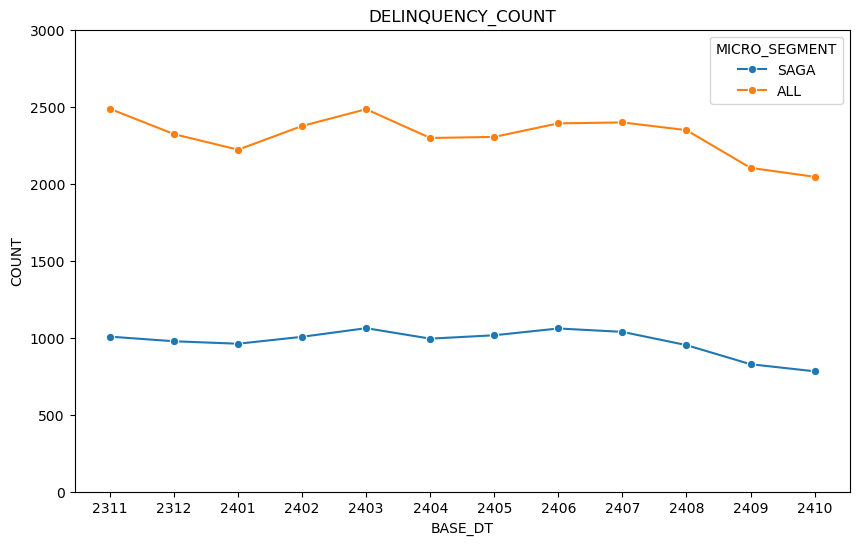

In [ ]:
# Plot delinquency count per month
plt.figure(figsize=(10,6))
plt.title("DELINQUENCY_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
plt.ylim((0,3000))
sns.lineplot(data=AllDeliCount, x="BASE_DT", y='ACCT_COUNT', hue='MICRO_SEGMENT', marker="o")

<Axes: title={'center': 'DELINQUENT_OS'}, xlabel='BASE_DT', ylabel='AMOUNT'>

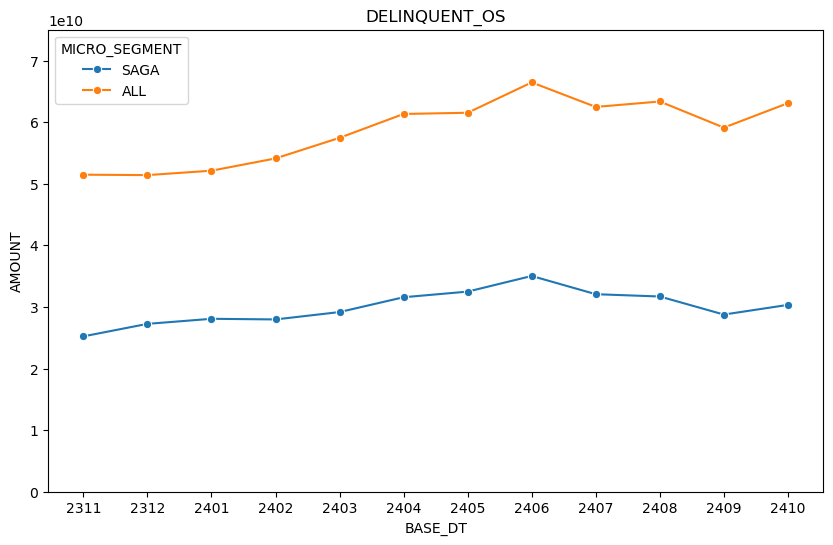

In [ ]:
# Plot delinquent OS per month
plt.figure(figsize=(10,6))
plt.title("DELINQUENT_OS")
plt.xlabel("BASE_DT")
plt.ylabel("AMOUNT")
plt.ylim((0,75000000000))
sns.lineplot(data=AllDeliCount, x="BASE_DT", y='OS', hue='MICRO_SEGMENT', marker="o")

### b. SAGA Total vs Delinquency

In [ ]:
# Total delinquency aggregate
SAGACount = MLs[(MLs['SAGA_FLAG']=='SAGA')][[
    'BASE_DT', 'AGREE_ID', 'BAL'
]].groupby('BASE_DT').agg(ACCT_COUNT=('AGREE_ID','count'),
                          OS=('BAL','sum')).reset_index()
SAGACount['MICRO_SEGMENT'] = 'SAGA'
SAGACount['CATEGORY'] = 'ALL'

In [ ]:
# concat the data
AllSAGACount = pd.concat([SAGADeliCount, SAGACount], ignore_index=True)

# format base_dt
AllSAGACount['BASE_DT'] = AllSAGACount['BASE_DT'].str[2:6]

In [ ]:
AllSAGACount

,BASE_DT,ACCT_COUNT,OS,MICRO_SEGMENT,CATEGORY
0,2311,1007,2.521953e+10,SAGA,DELINQUENT
1,2312,977,2.725033e+10,SAGA,DELINQUENT
2,2401,961,2.807185e+10,SAGA,DELINQUENT
3,2402,1006,2.796780e+10,SAGA,DELINQUENT
4,2403,1062,2.916743e+10,SAGA,DELINQUENT
5,2404,994,3.157295e+10,SAGA,DELINQUENT
6,2405,1016,3.248646e+10,SAGA,DELINQUENT
7,2406,1060,3.502505e+10,SAGA,DELINQUENT
8,2407,1038,3.206550e+10,SAGA,DELINQUENT
9,2408,952,3.169239e+10,SAGA,DELINQUENT


<Axes: title={'center': 'SAGA_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

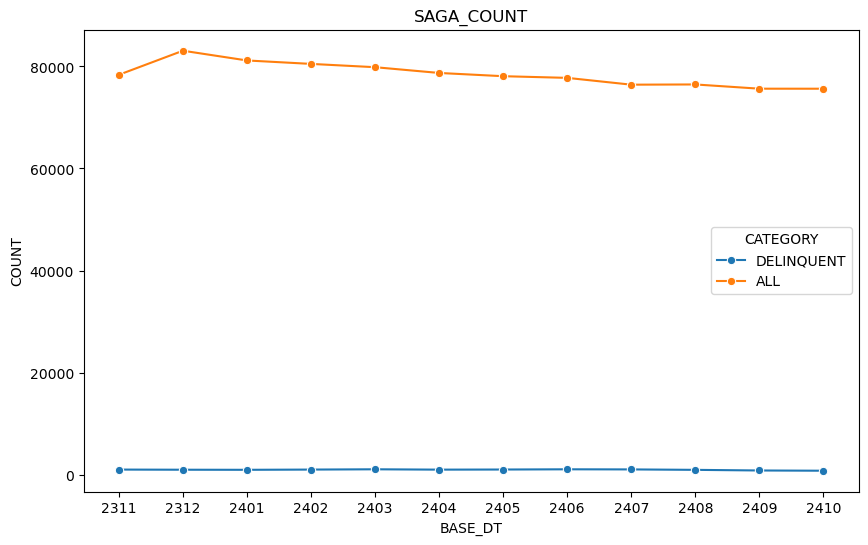

In [ ]:
# Plot SAGA count per month
plt.figure(figsize=(10,6))
plt.title("SAGA_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
# plt.ylim((0,2000))
sns.lineplot(data=AllSAGACount, x="BASE_DT", y='ACCT_COUNT', hue='CATEGORY', marker="o")

<Axes: title={'center': 'SAGA_OS'}, xlabel='BASE_DT', ylabel='COUNT'>

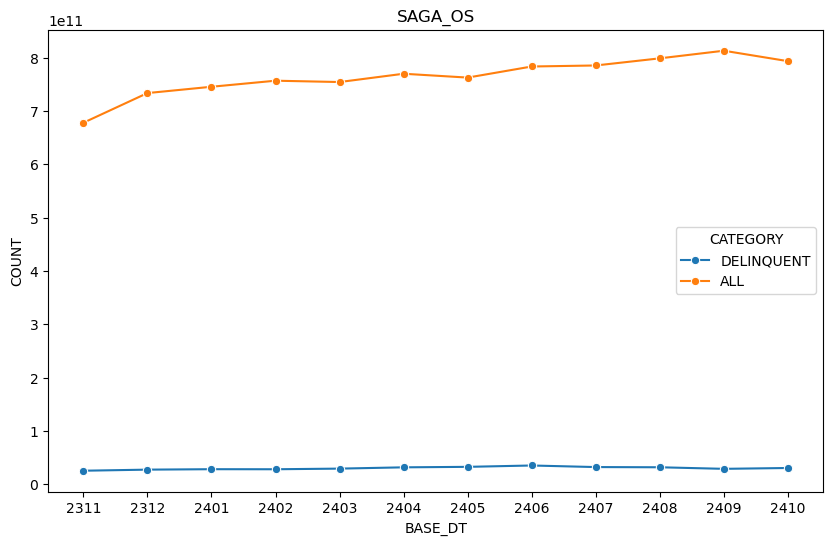

In [ ]:
# Plot SAGA count per month
plt.figure(figsize=(10,6))
plt.title("SAGA_OS")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
# plt.ylim((0,2000))
sns.lineplot(data=AllSAGACount, x="BASE_DT", y='OS', hue='CATEGORY', marker="o")

In [ ]:
# create wide df to calaculate percentage
AllSagaCountWide = AllSAGACount[AllSAGACount['CATEGORY']=='DELINQUENT'].merge(
    AllSAGACount[AllSAGACount['CATEGORY']=='ALL'], on='BASE_DT', how='left')

In [ ]:
# fix field names and shi
AllSagaCountWide.columns = ['BASE_DT', 'ACCT_COUNT_DELINQUENT', 'OS_DELINQUENT','MICRO_SEGMENT_x', 'CATEGORY_x',
       'ACCT_COUNT_ALL', 'OS_ALL', 'MICRO_SEGMENT', 'CATEGORY_y']
AllSagaCountWide = AllSagaCountWide[['BASE_DT', 'ACCT_COUNT_DELINQUENT', 'OS_DELINQUENT',
       'ACCT_COUNT_ALL', 'OS_ALL', 'MICRO_SEGMENT']]

In [ ]:
AllSagaCountWide

,BASE_DT,ACCT_COUNT_DELINQUENT,OS_DELINQUENT,ACCT_COUNT_ALL,OS_ALL,MICRO_SEGMENT
0,2311,1007,2.521953e+10,78358,6.778613e+11,SAGA
1,2312,977,2.725033e+10,83071,7.335104e+11,SAGA
2,2401,961,2.807185e+10,81163,7.453515e+11,SAGA
3,2402,1006,2.796780e+10,80489,7.567105e+11,SAGA
4,2403,1062,2.916743e+10,79843,7.542105e+11,SAGA
5,2404,994,3.157295e+10,78715,7.697663e+11,SAGA
6,2405,1016,3.248646e+10,78079,7.625431e+11,SAGA
7,2406,1060,3.502505e+10,77752,7.833538e+11,SAGA
8,2407,1038,3.206550e+10,76418,7.852823e+11,SAGA
9,2408,952,3.169239e+10,76462,7.986619e+11,SAGA


In [ ]:
# calculate count share
AllSagaCountWide['ACCT_COUNT_SHARE'] = AllSagaCountWide['ACCT_COUNT_DELINQUENT']/AllSagaCountWide['ACCT_COUNT_ALL']

# calculate os share
AllSagaCountWide['OS_SHARE'] = AllSagaCountWide['OS_DELINQUENT']/AllSagaCountWide['OS_ALL']

In [ ]:
# longify for visualization
CountShare = AllSagaCountWide[['BASE_DT','ACCT_COUNT_SHARE']]
CountShare.columns = ['BASE_DT','SHARE']
CountShare['VAR'] = 'COUNT'

OSShare = AllSagaCountWide[['BASE_DT','OS_SHARE']]
OSShare.columns = ['BASE_DT','SHARE']
OSShare['VAR'] = 'OS'

# concat the 2 tables
AllShare = pd.concat([CountShare,OSShare], ignore_index=True)
AllShare['BASE_DT'] = AllShare['BASE_DT'].str[2:6]

C:\Users\MR38804\AppData\Local\Temp\ipykernel_15760\2811820419.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CountShare['VAR'] = 'COUNT'
C:\Users\MR38804\AppData\Local\Temp\ipykernel_15760\2811820419.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OSShare['VAR'] = 'OS'


<Axes: title={'center': 'SAGA_DELINQUENCY_SHARE'}, xlabel='BASE_DT', ylabel='SHARE'>

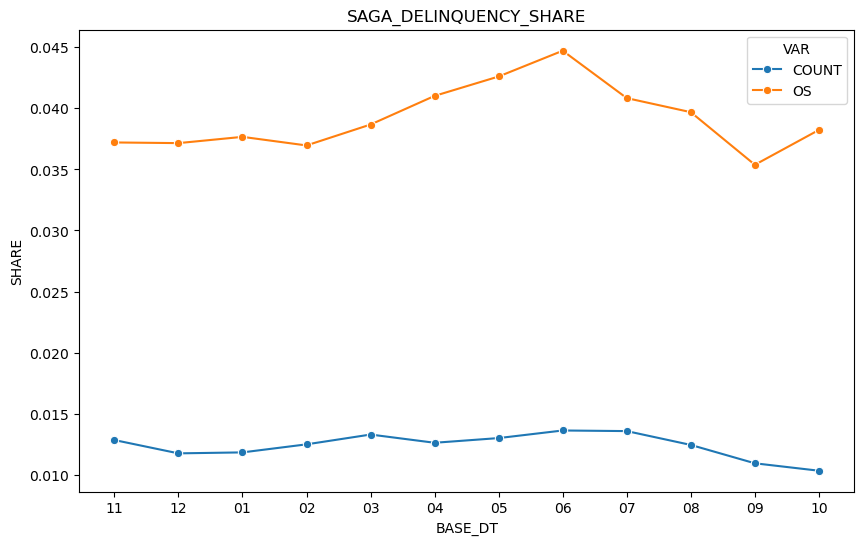

In [ ]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("SAGA_DELINQUENCY_SHARE")
plt.xlabel("BASE_DT")
plt.ylabel("SHARE")
sns.lineplot(data=AllShare, x="BASE_DT", y='SHARE', hue='VAR', marker="o")

### c. All Total vs Delinquent

In [ ]:
# total deli count (review)
TotalDeliCount

,BASE_DT,ACCT_COUNT,OS,MICRO_SEGMENT,CATEGORY
0,20231130,2486,5.146517e+10,ALL,DELINQUENT
1,20231229,2322,5.139953e+10,ALL,DELINQUENT
2,20240131,2221,5.211538e+10,ALL,DELINQUENT
3,20240229,2375,5.410855e+10,ALL,DELINQUENT
4,20240328,2484,5.745158e+10,ALL,DELINQUENT
5,20240430,2297,6.132662e+10,ALL,DELINQUENT
6,20240531,2304,6.151929e+10,ALL,DELINQUENT
7,20240628,2392,6.644884e+10,ALL,DELINQUENT
8,20240731,2398,6.246609e+10,ALL,DELINQUENT
9,20240829,2348,6.334926e+10,ALL,DELINQUENT


In [ ]:
# Total aggregate
TotalCount = MLs[[
    'BASE_DT', 'AGREE_ID', 'BAL'
]].groupby('BASE_DT').agg(ACCT_COUNT=('AGREE_ID','count'),
                          OS=('BAL','sum')).reset_index()
TotalCount['MICRO_SEGMENT'] = 'ALL'
TotalCount['CATEGORY'] = 'ALL'

In [ ]:
# concat tables
AllAll = pd.concat([TotalDeliCount,TotalCount], ignore_index=True)

# format base_dt
AllAll['BASE_DT'] = AllAll['BASE_DT'].str[2:6]

In [ ]:
AllAll

,BASE_DT,ACCT_COUNT,OS,MICRO_SEGMENT,CATEGORY
0,2311,2486,5.146517e+10,ALL,DELINQUENT
1,2312,2322,5.139953e+10,ALL,DELINQUENT
2,2401,2221,5.211538e+10,ALL,DELINQUENT
3,2402,2375,5.410855e+10,ALL,DELINQUENT
4,2403,2484,5.745158e+10,ALL,DELINQUENT
5,2404,2297,6.132662e+10,ALL,DELINQUENT
6,2405,2304,6.151929e+10,ALL,DELINQUENT
7,2406,2392,6.644884e+10,ALL,DELINQUENT
8,2407,2398,6.246609e+10,ALL,DELINQUENT
9,2408,2348,6.334926e+10,ALL,DELINQUENT


<Axes: title={'center': 'ALL_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

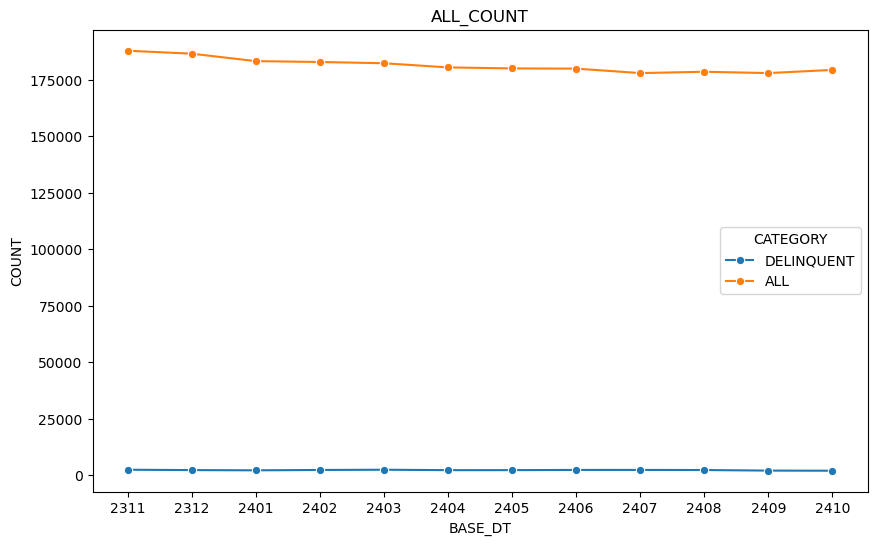

In [ ]:
# Plot All count per month
plt.figure(figsize=(10,6))
plt.title("ALL_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
# plt.ylim((0,2000))
sns.lineplot(data=AllAll, x="BASE_DT", y='ACCT_COUNT', hue='CATEGORY', marker="o")

<Axes: title={'center': 'ALL_OS'}, xlabel='BASE_DT', ylabel='OS'>

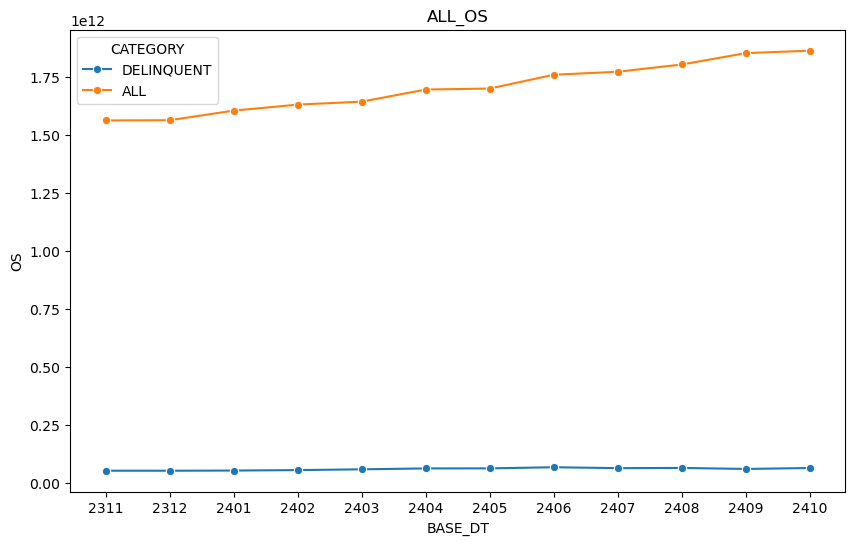

In [ ]:
# Plot All count per month
plt.figure(figsize=(10,6))
plt.title("ALL_OS")
plt.xlabel("BASE_DT")
plt.ylabel("OS")
# plt.ylim((0,2000))
sns.lineplot(data=AllAll, x="BASE_DT", y='OS', hue='CATEGORY', marker="o")

In [ ]:
# create wide df to calaculate percentage
AllCountWide = AllAll[AllAll['CATEGORY']=='DELINQUENT'].merge(
    AllAll[AllAll['CATEGORY']=='ALL'], on='BASE_DT', how='left')

In [ ]:
# fix field names and shi
AllCountWide.columns = ['BASE_DT', 'ACCT_COUNT_DELINQUENT', 'OS_DELINQUENT','MICRO_SEGMENT_x', 'CATEGORY_x',
       'ACCT_COUNT_ALL', 'OS_ALL', 'MICRO_SEGMENT', 'CATEGORY_y']
AllCountWide = AllCountWide[['BASE_DT', 'ACCT_COUNT_DELINQUENT', 'OS_DELINQUENT',
       'ACCT_COUNT_ALL', 'OS_ALL', 'MICRO_SEGMENT']]

In [ ]:
# calculate count share
AllCountWide['ACCT_COUNT_SHARE'] = AllCountWide['ACCT_COUNT_DELINQUENT']/AllCountWide['ACCT_COUNT_ALL']

# calculate os share
AllCountWide['OS_SHARE'] = AllCountWide['OS_DELINQUENT']/AllCountWide['OS_ALL']

In [ ]:
# longify for visualization
AllCountShare = AllCountWide[['BASE_DT','ACCT_COUNT_SHARE']]
AllCountShare.columns = ['BASE_DT','SHARE']
AllCountShare['VAR'] = 'COUNT'

AllOSShare = AllCountWide[['BASE_DT','OS_SHARE']]
AllOSShare.columns = ['BASE_DT','SHARE']
AllOSShare['VAR'] = 'OS'

# concat the 2 tables
AllAllShare = pd.concat([AllCountShare,AllOSShare], ignore_index=True)
#AllAllShare['BASE_DT'] = AllAllShare['BASE_DT'].str[2:6]

C:\Users\MR38804\AppData\Local\Temp\ipykernel_15760\1748476280.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AllCountShare['VAR'] = 'COUNT'
C:\Users\MR38804\AppData\Local\Temp\ipykernel_15760\1748476280.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AllOSShare['VAR'] = 'OS'


<Axes: title={'center': 'TOTAL_DELINQUENCY_SHARE'}, xlabel='BASE_DT', ylabel='SHARE'>

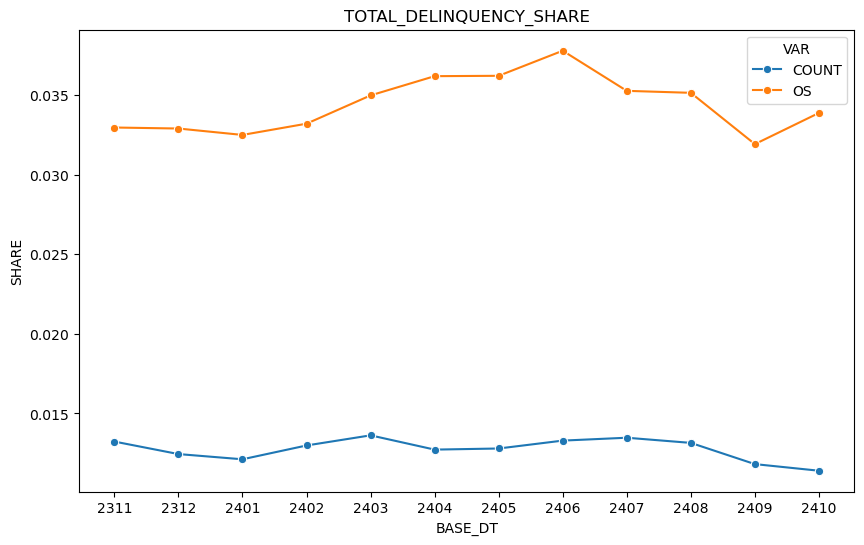

In [ ]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("TOTAL_DELINQUENCY_SHARE")
plt.xlabel("BASE_DT")
plt.ylabel("SHARE")
sns.lineplot(data=AllAllShare, x="BASE_DT", y='SHARE', hue='VAR', marker="o")

### d. SAGA Monthly New Delinquent

In [ ]:
# set dataframe for dpd change calculation
DPDMonthly = MLs[['BASE_DT', 'AGREE_ID', 'PASTDUE_DAYS']].reset_index()

In [ ]:
# checking pastdue values
DPDMonthly['PASTDUE_DAYS'].value_counts()

PASTDUE_DAYS
0      2108866
1        40809
30       10727
60        6189
90        4365
120       3585
150       2842
210         62
180          5
Name: count, dtype: int64

In [ ]:
# create pivot table
DPDMonthlyPivot = DPDMonthly.pivot(index='AGREE_ID',
                                   columns='BASE_DT',
                                   values='PASTDUE_DAYS')

In [ ]:
# flaten columns
DPDMonthlyPivot = DPDMonthlyPivot.rename_axis(index=None, columns=None).reset_index()

In [ ]:
DPDMonthlyPivot.columns

Index(['index', '20231130', '20231229', '20240131', '20240229', '20240328',
       '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
       '20241031'],
      dtype='object')

In [ ]:
# rename columns
DPDMonthlyPivot.columns = [
    'AGREE_ID', '20231130', '20231229', '20240131', '20240229', '20240328',
    '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
    '20241031']

In [ ]:
# fillna with 0
DPDMonthlyPivot.fillna(0, inplace=True)

# date for loop
dateCol = ['20231130', '20231229', '20240131', '20240229', '20240328',
    '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
    '20241031']

# calculate dpd change for all dates
for i in range(1,len(dateCol)):
    prevDate = dateCol[i-1]
    date = dateCol[i]
    DPDMonthlyPivot[f'DELINQUENT_{date}'] = DPDMonthlyPivot.apply(
        lambda x: 1 if x[prevDate]<30 and x[date]>=30 else 0,
        axis=1)

In [ ]:
# check value
DPDMonthlyPivot[['DELINQUENT_20240430']].value_counts()

DELINQUENT_20240430
0                      255118
1                         579
Name: count, dtype: int64

In [ ]:
# take only used cols
usedCols = [list(DPDMonthlyPivot.columns)[0]]+list(DPDMonthlyPivot.columns)[13:]
DPDMonthlyPivot = DPDMonthlyPivot[usedCols]

In [ ]:
# longify
DPDMonthlyLong = pd.wide_to_long(DPDMonthlyPivot,
                                 stubnames='DELINQUENT',
                                 i = 'AGREE_ID',
                                 j = 'BASE_DT',
                                 sep = '_')

In [ ]:
# reset index and change base_dt type to string
DPDMonthlyLong = DPDMonthlyLong.reset_index()
DPDMonthlyLong['BASE_DT'] = DPDMonthlyLong['BASE_DT'].astype(str)

In [ ]:
DPDMonthlyLong.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2812667 entries, 0 to 2812666
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   AGREE_ID    object
 1   BASE_DT     object
 2   DELINQUENT  int64 
dtypes: int64(1), object(2)
memory usage: 64.4+ MB


In [ ]:
# merge delinquency flag to original data
MLs = MLs.merge(DPDMonthlyLong[['AGREE_ID', 'BASE_DT', 'DELINQUENT']], on=['AGREE_ID', 'BASE_DT'], how='left')

In [ ]:
MLs['DELINQUENT'].value_counts()

DELINQUENT
0.0    1982292
1.0       7273
Name: count, dtype: int64

In [ ]:
# group data for visualization
monthlyDeli = MLs[(MLs['SAGA_FLAG']=='SAGA') & (MLs['DELINQUENT']==1)][['BASE_DT', 'DELINQUENT', 'BAL']].groupby('BASE_DT').agg(ACCT_COUNT=('DELINQUENT','sum'), OS=('BAL','sum')).reset_index()
monthlyDeliAll = MLs[MLs['DELINQUENT']==1][['BASE_DT', 'DELINQUENT','BAL']].groupby('BASE_DT').agg(ACCT_COUNT=('DELINQUENT','sum'), OS=('BAL','sum')).reset_index()

In [ ]:
# flag data
monthlyDeli['MICRO_SEGMENT'] = 'SAGA'
monthlyDeliAll['MICRO_SEGMENT'] = 'ALL'

In [ ]:
# combine the data
MonthlyDeliComb = pd.concat([monthlyDeli,monthlyDeliAll], ignore_index=True)

# format data
MonthlyDeliComb['BASE_DT'] = MonthlyDeliComb['BASE_DT'].str[2:6]

# exclude first month because no data of new delinquency
MonthlyDeliComb = MonthlyDeliComb[MonthlyDeliComb['BASE_DT']!='2311']

<Axes: title={'center': 'MONTHLY_DELINQUENCY_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

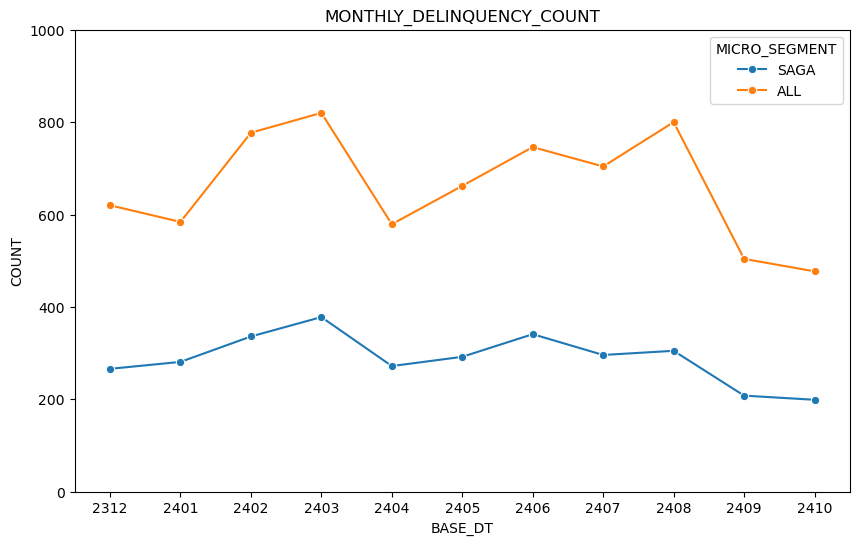

In [ ]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("MONTHLY_DELINQUENCY_COUNT")
plt.xlabel("BASE_DT")
plt.ylim((0,1000))
plt.ylabel("COUNT")
sns.lineplot(data=MonthlyDeliComb, x="BASE_DT", y='ACCT_COUNT', hue='MICRO_SEGMENT', marker="o")

<Axes: title={'center': 'MONTHLY_DELINQUENCY_os'}, xlabel='BASE_DT', ylabel='os'>

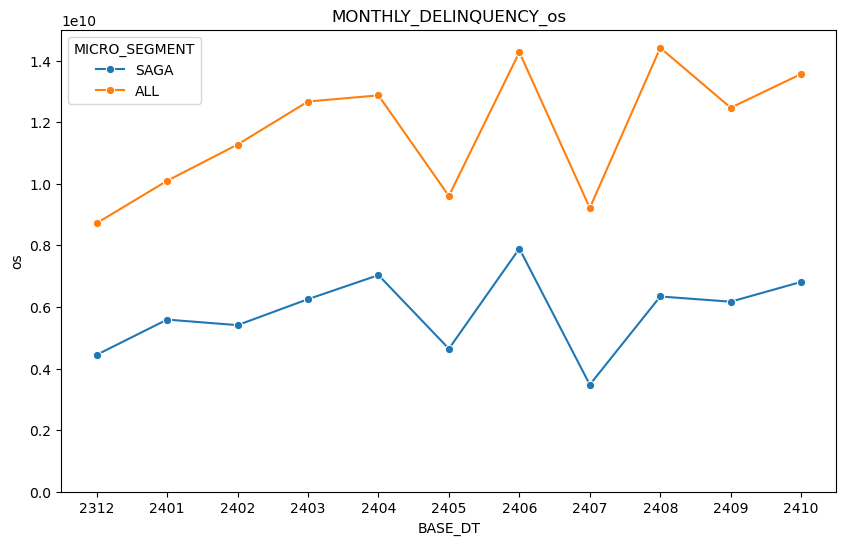

In [ ]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("MONTHLY_DELINQUENCY_os")
plt.xlabel("BASE_DT")
plt.ylim((0,15000000000))
plt.ylabel("os")
sns.lineplot(data=MonthlyDeliComb, x="BASE_DT", y='OS', hue='MICRO_SEGMENT', marker="o")

## 2. By GCIF

In [ ]:
# create GCIF grouped data
MLsGCIFGPD = MLs[['BASE_DT','GCIF_NO','CURR_LMT_AMT','BAL']].groupby(
    ['BASE_DT','GCIF_NO']).agg(
        SUM_LMT=('CURR_LMT_AMT','sum'),
        SUM_BAL=('BAL','sum'),
        NOA=('BASE_DT','count')
    ).reset_index()

In [ ]:
# create separate df for categorical
MLsGCIFProc = MLs[['BASE_DT','GCIF_NO','SAGA_FLAG','PASTDUE_DAYS']]

In [ ]:
# map to integer SAGA flag
SAGAMap = {'SAGA':1,'NON-SAGA':0}
MLsGCIFProc['SAGA_FLAG'] = MLsGCIFProc['SAGA_FLAG'].map(SAGAMap)

C:\Users\MR38804\AppData\Local\Temp\ipykernel_15760\49022384.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MLsGCIFProc['SAGA_FLAG'] = MLsGCIFProc['SAGA_FLAG'].map(SAGAMap)


In [ ]:
# create categorical GCIF grouped data
MLsGCIFGPD2 = MLsGCIFProc.groupby(
    ['BASE_DT','GCIF_NO']).agg(
        SAGA_FLAG=('SAGA_FLAG','max'),
        PASTDUE_DAYS_MAX=('PASTDUE_DAYS','max'),
).reset_index()

In [ ]:
MLsGCIFGPD.duplicated(subset=['BASE_DT','GCIF_NO']).sum()

0

In [ ]:
MLsGCIFGPD2.duplicated(subset=['BASE_DT','GCIF_NO']).sum()

0

In [ ]:
# merge the numeric and categorical data
MLsGCIF = MLsGCIFGPD.merge(MLsGCIFGPD2, on=['BASE_DT','GCIF_NO'], how='left')

In [ ]:
# map data
MLsGCIF['SAGA_FLAG'] = MLsGCIF['SAGA_FLAG'].map({1:'SAGA',0:'NON-SAGA'})
MLsGCIF['CC_STATUS'] = MLsGCIF.apply(
    lambda x: 'DELINQUENT' if x['PASTDUE_DAYS_MAX']>=30 else 'PERFORMING' if x['PASTDUE_DAYS_MAX']==0 else 'GRACE_PERIOD',
    axis=1)

In [ ]:
MLsGCIF[MLsGCIF['SAGA_FLAG']=='SAGA'][['PASTDUE_DAYS_MAX','CC_STATUS']].value_counts()

PASTDUE_DAYS_MAX  CC_STATUS   
0                 PERFORMING      553248
1                 GRACE_PERIOD     15501
30                DELINQUENT        4013
60                DELINQUENT        2112
90                DELINQUENT        1519
120               DELINQUENT        1277
150               DELINQUENT        1043
210               DELINQUENT          30
180               DELINQUENT           1
Name: count, dtype: int64

In [ ]:
MLsGCIF[MLsGCIF['SAGA_FLAG']=='SAGA'][['PASTDUE_DAYS_MAX','CC_STATUS']].value_counts()

PASTDUE_DAYS_MAX  CC_STATUS   
0                 PERFORMING      553248
1                 GRACE_PERIOD     15501
30                DELINQUENT        4013
60                DELINQUENT        2112
90                DELINQUENT        1519
120               DELINQUENT        1277
150               DELINQUENT        1043
210               DELINQUENT          30
180               DELINQUENT           1
Name: count, dtype: int64

In [ ]:
# Total all GCIF aggregate
TotalGCIFCount = MLsGCIF.groupby('BASE_DT').agg(
    CUST_NUM=('GCIF_NO','count'),
    TOTAL_LMT=('SUM_LMT','sum'),
    TOTAL_BAL=('SUM_BAL','sum'),
    TOTAL_NOA=('NOA','sum'),
).reset_index()
TotalGCIFCount['MICRO_SEGMENT'] = 'ALL'
TotalGCIFCount['CATEGORY'] = 'ALL'

In [ ]:
TotalGCIFCount

,BASE_DT,CUST_NUM,TOTAL_LMT,TOTAL_BAL,TOTAL_NOA,MICRO_SEGMENT,CATEGORY
0,20231130,123670,3.749174e+12,1.561560e+12,187885,ALL,ALL
1,20231229,123424,3.775570e+12,1.562580e+12,186569,ALL,ALL
2,20240131,122366,3.848475e+12,1.603963e+12,183281,ALL,ALL
3,20240229,122966,3.925737e+12,1.629879e+12,182894,ALL,ALL
4,20240328,123125,3.935050e+12,1.642677e+12,182350,ALL,ALL
5,20240430,122583,3.977078e+12,1.694901e+12,180496,ALL,ALL
6,20240531,122389,4.037320e+12,1.699164e+12,180056,ALL,ALL
7,20240628,122319,4.130127e+12,1.758796e+12,179964,ALL,ALL
8,20240731,121272,4.370452e+12,1.771556e+12,177991,ALL,ALL
9,20240829,121461,4.406276e+12,1.802961e+12,178580,ALL,ALL


In [ ]:
# Total delinquent GCIF aggregate
TotalDeliGCIFCount = MLsGCIF[MLsGCIF['CC_STATUS']=='DELINQUENT'].groupby('BASE_DT').agg(
    CUST_NUM=('GCIF_NO','count'),
    TOTAL_LMT=('SUM_LMT','sum'),
    TOTAL_BAL=('SUM_BAL','sum'),
    TOTAL_NOA=('NOA','sum'),
).reset_index()
TotalDeliGCIFCount['MICRO_SEGMENT'] = 'ALL'
TotalDeliGCIFCount['CATEGORY'] = 'DELINQUENT'

In [ ]:
TotalDeliGCIFCount

,BASE_DT,CUST_NUM,TOTAL_LMT,TOTAL_BAL,TOTAL_NOA,MICRO_SEGMENT,CATEGORY
0,20231130,2175,6.128504e+10,5.315763e+10,3104,ALL,DELINQUENT
1,20231229,2038,6.166476e+10,5.283136e+10,2822,ALL,DELINQUENT
2,20240131,1942,6.137461e+10,5.331345e+10,2672,ALL,DELINQUENT
3,20240229,2089,6.659679e+10,5.579830e+10,2900,ALL,DELINQUENT
4,20240328,2189,7.284497e+10,5.955540e+10,3071,ALL,DELINQUENT
5,20240430,2005,7.170135e+10,6.292393e+10,2849,ALL,DELINQUENT
6,20240531,2004,7.224180e+10,6.374632e+10,2893,ALL,DELINQUENT
7,20240628,2075,7.999564e+10,6.862940e+10,3068,ALL,DELINQUENT
8,20240731,2117,7.601516e+10,6.462509e+10,3119,ALL,DELINQUENT
9,20240829,2038,7.555920e+10,6.527866e+10,2875,ALL,DELINQUENT


In [ ]:
# Total SAGA GCIF aggregate
SAGAGCIFCount = MLsGCIF[MLsGCIF['SAGA_FLAG']=='SAGA'].groupby('BASE_DT').agg(
    CUST_NUM=('GCIF_NO','count'),
    TOTAL_LMT=('SUM_LMT','sum'),
    TOTAL_BAL=('SUM_BAL','sum'),
    TOTAL_NOA=('NOA','sum'),
).reset_index()
SAGAGCIFCount['MICRO_SEGMENT'] = 'SAGA'
SAGAGCIFCount['CATEGORY'] = 'ALL'

In [ ]:
# Total SAGA delinquent GCIF aggregate
SAGADeliGCIFCount = MLsGCIF[(MLsGCIF['SAGA_FLAG']=='SAGA')&(MLsGCIF['CC_STATUS']=='DELINQUENT')].groupby('BASE_DT').agg(
    CUST_NUM=('GCIF_NO','count'),
    TOTAL_LMT=('SUM_LMT','sum'),
    TOTAL_BAL=('SUM_BAL','sum'),
    TOTAL_NOA=('NOA','sum'),
).reset_index()
SAGADeliGCIFCount['MICRO_SEGMENT'] = 'SAGA'
SAGADeliGCIFCount['CATEGORY'] = 'DELINQUENT'

In [ ]:
TotalGCIFCount

,BASE_DT,CUST_NUM,TOTAL_LMT,TOTAL_BAL,TOTAL_NOA,MICRO_SEGMENT,CATEGORY
0,20231130,123670,3.749174e+12,1.561560e+12,187885,ALL,ALL
1,20231229,123424,3.775570e+12,1.562580e+12,186569,ALL,ALL
2,20240131,122366,3.848475e+12,1.603963e+12,183281,ALL,ALL
3,20240229,122966,3.925737e+12,1.629879e+12,182894,ALL,ALL
4,20240328,123125,3.935050e+12,1.642677e+12,182350,ALL,ALL
5,20240430,122583,3.977078e+12,1.694901e+12,180496,ALL,ALL
6,20240531,122389,4.037320e+12,1.699164e+12,180056,ALL,ALL
7,20240628,122319,4.130127e+12,1.758796e+12,179964,ALL,ALL
8,20240731,121272,4.370452e+12,1.771556e+12,177991,ALL,ALL
9,20240829,121461,4.406276e+12,1.802961e+12,178580,ALL,ALL


### a. SAGA vs ALL Delinquency

<Axes: title={'center': 'DELINQUENCY_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

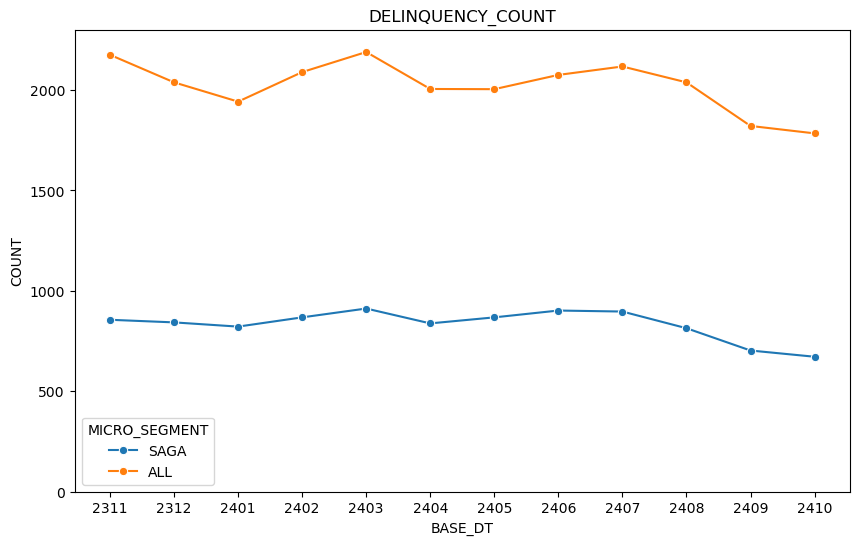

In [ ]:
# concat data
GCIFPlot1 = pd.concat([SAGADeliGCIFCount,TotalDeliGCIFCount])
GCIFPlot1['BASE_DT'] = GCIFPlot1['BASE_DT'].str[2:6]

# Plot delinquency count per month
plt.figure(figsize=(10,6))
plt.title("DELINQUENCY_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
plt.ylim((0,2300))
sns.lineplot(data=GCIFPlot1, x="BASE_DT", y='CUST_NUM', hue='MICRO_SEGMENT', marker="o")

### b. SAGA Total vs Delinquency

<Axes: title={'center': 'SAGA_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

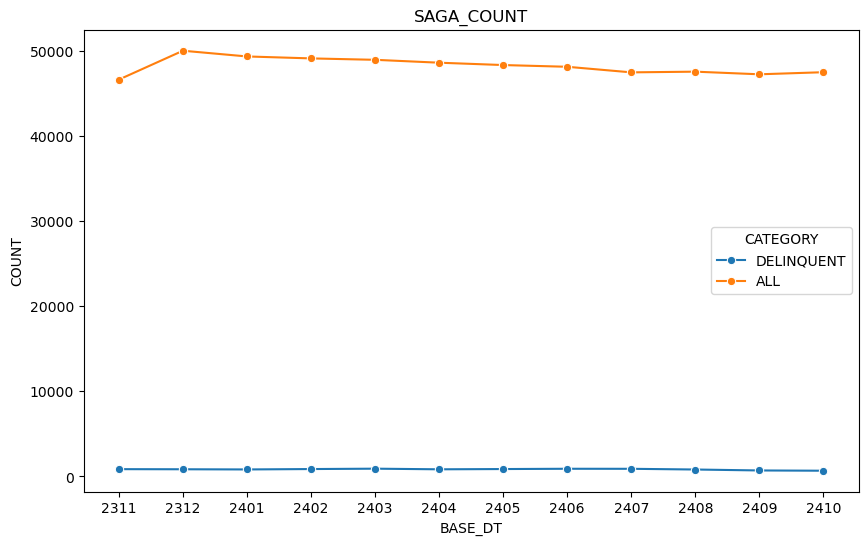

In [ ]:
# concat data
GCIFPlot2 = pd.concat([SAGADeliGCIFCount,SAGAGCIFCount])
GCIFPlot2['BASE_DT'] = GCIFPlot2['BASE_DT'].str[2:6]

# Plot delinquency count per month
plt.figure(figsize=(10,6))
plt.title("SAGA_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
#plt.ylim((0,2300))
sns.lineplot(data=GCIFPlot2, x="BASE_DT", y='CUST_NUM', hue='CATEGORY', marker="o")

In [ ]:
GCIFPlot2

,BASE_DT,CUST_NUM,TOTAL_LMT,TOTAL_BAL,TOTAL_NOA,MICRO_SEGMENT,CATEGORY
0,2311,856,3.041434e+10,2.624876e+10,1332,SAGA,DELINQUENT
1,2312,843,3.293608e+10,2.833948e+10,1247,SAGA,DELINQUENT
2,2401,822,3.268571e+10,2.886060e+10,1195,SAGA,DELINQUENT
3,2402,868,3.529419e+10,2.912786e+10,1289,SAGA,DELINQUENT
4,2403,912,3.775471e+10,3.052602e+10,1377,SAGA,DELINQUENT
5,2404,838,3.691178e+10,3.256694e+10,1291,SAGA,DELINQUENT
6,2405,868,3.883794e+10,3.392324e+10,1355,SAGA,DELINQUENT
7,2406,902,4.193386e+10,3.643035e+10,1414,SAGA,DELINQUENT
8,2407,897,3.868926e+10,3.298614e+10,1383,SAGA,DELINQUENT
9,2408,814,3.820568e+10,3.278221e+10,1211,SAGA,DELINQUENT


In [ ]:
# create wide df to calaculate percentage
GCIFPlot2Wide = GCIFPlot2[GCIFPlot2['CATEGORY']=='DELINQUENT'].merge(
    GCIFPlot2[GCIFPlot2['CATEGORY']=='ALL'], on='BASE_DT', how='left')

In [ ]:
GCIFPlot2Wide.columns

Index(['BASE_DT', 'CUST_NUM_x', 'TOTAL_LMT_x', 'TOTAL_BAL_x', 'TOTAL_NOA_x',
       'MICRO_SEGMENT_x', 'CATEGORY_x', 'CUST_NUM_y', 'TOTAL_LMT_y',
       'TOTAL_BAL_y', 'TOTAL_NOA_y', 'MICRO_SEGMENT_y', 'CATEGORY_y'],
      dtype='object')

In [ ]:
# fix field names and shi
GCIFPlot2Wide.columns = ['BASE_DT', 'CUST_NUM_DELINQUENT', 'TOTAL_LMT_DELINQUENT',
                            'TOTAL_BAL_DELINQUENT', 'TOTAL_NOA_DELINQUENT', 'MICRO_SEGMENT_x',
                            'CATEGORY_x', 'CUST_NUM_ALL', 'TOTAL_LMT_ALL',
                            'TOTAL_BAL_ALL', 'TOTAL_NOA_ALL','MICRO_SEGMENT', 'CATEGORY_y']
GCIFPlot2Wide = GCIFPlot2Wide[['BASE_DT', 'CUST_NUM_DELINQUENT', 'TOTAL_LMT_DELINQUENT',
                            'TOTAL_BAL_DELINQUENT', 'TOTAL_NOA_DELINQUENT',
                            'CUST_NUM_ALL', 'TOTAL_LMT_ALL',
                            'TOTAL_BAL_ALL', 'TOTAL_NOA_ALL','MICRO_SEGMENT']]

In [ ]:
# calculate count share
GCIFPlot2Wide['CUST_NUM_SHARE'] = GCIFPlot2Wide['CUST_NUM_DELINQUENT']/GCIFPlot2Wide['CUST_NUM_ALL']

# calculate os share
GCIFPlot2Wide['OS_SHARE'] = GCIFPlot2Wide['TOTAL_BAL_DELINQUENT']/GCIFPlot2Wide['TOTAL_BAL_ALL']

In [ ]:
# longify for visualization
GCIFCountShare = GCIFPlot2Wide[['BASE_DT','CUST_NUM_SHARE']]
GCIFCountShare.columns = ['BASE_DT','SHARE']
GCIFCountShare['VAR'] = 'GCIF_COUNT'

GCIFOSShare = GCIFPlot2Wide[['BASE_DT','OS_SHARE']]
GCIFOSShare.columns = ['BASE_DT','SHARE']
GCIFOSShare['VAR'] = 'OS'

# concat the 2 tables
GCIFAllShare = pd.concat([GCIFCountShare,GCIFOSShare], ignore_index=True)
GCIFAllShare['BASE_DT'] = GCIFAllShare['BASE_DT'].str[2:6]

C:\Users\MR38804\AppData\Local\Temp\ipykernel_15760\2687063092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GCIFCountShare['VAR'] = 'GCIF_COUNT'
C:\Users\MR38804\AppData\Local\Temp\ipykernel_15760\2687063092.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GCIFOSShare['VAR'] = 'OS'


<Axes: title={'center': 'SAGA_DELINQUENCY_SHARE'}, xlabel='BASE_DT', ylabel='SHARE'>

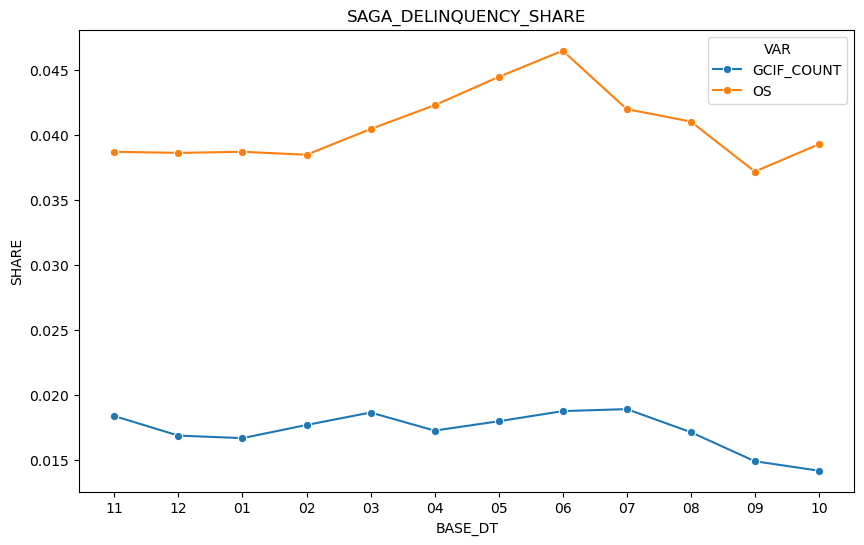

In [ ]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("SAGA_DELINQUENCY_SHARE")
plt.xlabel("BASE_DT")
plt.ylabel("SHARE")
sns.lineplot(data=GCIFAllShare, x="BASE_DT", y='SHARE', hue='VAR', marker="o")

### c. All Total vs Delinquent

<Axes: title={'center': 'ALL_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

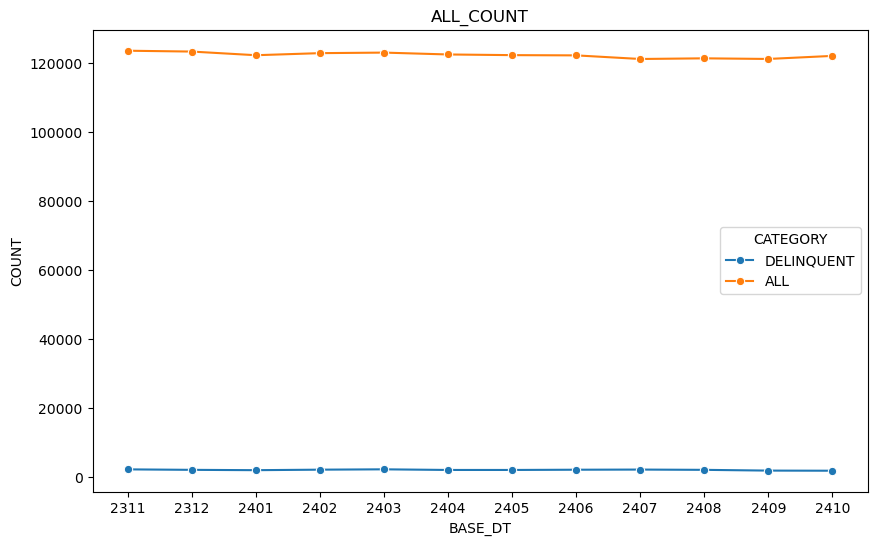

In [ ]:
# concat data
GCIFPlot3 = pd.concat([TotalDeliGCIFCount,TotalGCIFCount])
GCIFPlot3['BASE_DT'] = GCIFPlot3['BASE_DT'].str[2:6]

# Plot delinquency count per month
plt.figure(figsize=(10,6))
plt.title("ALL_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
#plt.ylim((0,2300))
sns.lineplot(data=GCIFPlot3, x="BASE_DT", y='CUST_NUM', hue='CATEGORY', marker="o")

In [ ]:
# create wide df to calaculate percentage
GCIFPlot3Wide = GCIFPlot3[GCIFPlot3['CATEGORY']=='DELINQUENT'].merge(
    GCIFPlot3[GCIFPlot3['CATEGORY']=='ALL'], on='BASE_DT', how='left')

In [ ]:
# fix field names and shi
GCIFPlot3Wide.columns = ['BASE_DT', 'CUST_NUM_DELINQUENT', 'TOTAL_LMT_DELINQUENT',
                            'TOTAL_BAL_DELINQUENT', 'TOTAL_NOA_DELINQUENT', 'MICRO_SEGMENT_x',
                            'CATEGORY_x', 'CUST_NUM_ALL', 'TOTAL_LMT_ALL',
                            'TOTAL_BAL_ALL', 'TOTAL_NOA_ALL','MICRO_SEGMENT', 'CATEGORY_y']
GCIFPlot3Wide = GCIFPlot3Wide[['BASE_DT', 'CUST_NUM_DELINQUENT', 'TOTAL_LMT_DELINQUENT',
                            'TOTAL_BAL_DELINQUENT', 'TOTAL_NOA_DELINQUENT',
                            'CUST_NUM_ALL', 'TOTAL_LMT_ALL',
                            'TOTAL_BAL_ALL', 'TOTAL_NOA_ALL','MICRO_SEGMENT']]

In [ ]:
# calculate count share
GCIFPlot3Wide['CUST_NUM_SHARE'] = GCIFPlot3Wide['CUST_NUM_DELINQUENT']/GCIFPlot3Wide['CUST_NUM_ALL']

# calculate os share
GCIFPlot3Wide['OS_SHARE'] = GCIFPlot3Wide['TOTAL_BAL_DELINQUENT']/GCIFPlot3Wide['TOTAL_BAL_ALL']

In [ ]:
# longify for visualization
AllGCIFCountShare = GCIFPlot3Wide[['BASE_DT','CUST_NUM_SHARE']]
AllGCIFCountShare.columns = ['BASE_DT','SHARE']
AllGCIFCountShare['VAR'] = 'GCIF_COUNT'

AllGCIFOSShare = GCIFPlot3Wide[['BASE_DT','OS_SHARE']]
AllGCIFOSShare.columns = ['BASE_DT','SHARE']
AllGCIFOSShare['VAR'] = 'OS'

# concat the 2 tables
AllGCIFAllShare = pd.concat([AllGCIFCountShare,AllGCIFOSShare], ignore_index=True)
AllGCIFAllShare['BASE_DT'] = AllGCIFAllShare['BASE_DT'].str[2:6]

C:\Users\MR38804\AppData\Local\Temp\ipykernel_15760\3087575407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AllGCIFCountShare['VAR'] = 'GCIF_COUNT'
C:\Users\MR38804\AppData\Local\Temp\ipykernel_15760\3087575407.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AllGCIFOSShare['VAR'] = 'OS'


<Axes: title={'center': 'ALL_DELINQUENCY_SHARE'}, xlabel='BASE_DT', ylabel='SHARE'>

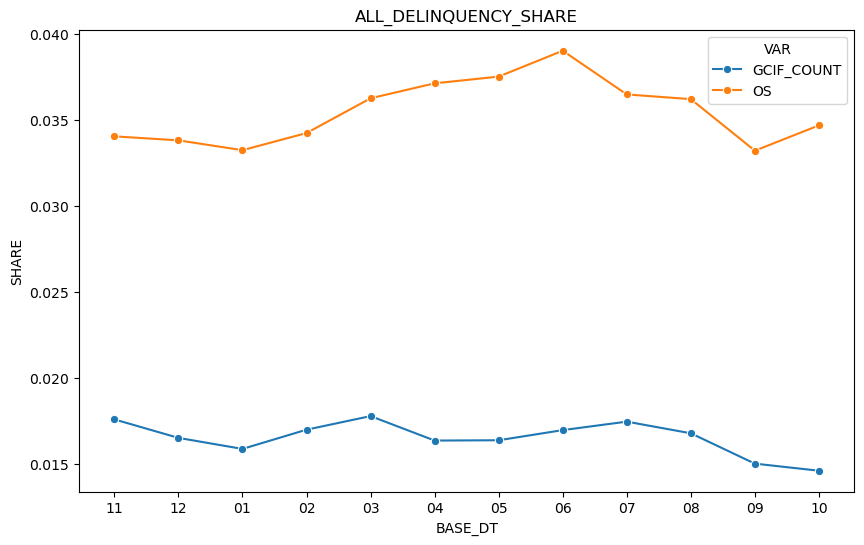

In [ ]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("ALL_DELINQUENCY_SHARE")
plt.xlabel("BASE_DT")
plt.ylabel("SHARE")
sns.lineplot(data=AllGCIFAllShare, x="BASE_DT", y='SHARE', hue='VAR', marker="o")

### d. SAGA Monthly New Delinquent

In [ ]:
# set dataframe for dpd change calculation
DPDMonthlyGCIF = MLsGCIF[['BASE_DT', 'GCIF_NO', 'PASTDUE_DAYS_MAX']].reset_index()

In [ ]:
# create pivot table
DPDMonthlyGCIFPivot = DPDMonthlyGCIF.pivot(index='GCIF_NO',
                                   columns='BASE_DT',
                                   values='PASTDUE_DAYS_MAX')

In [ ]:
# flaten columns
DPDMonthlyGCIFPivot = DPDMonthlyGCIFPivot.rename_axis(index=None, columns=None).reset_index()

In [ ]:
DPDMonthlyGCIFPivot.columns

Index(['index', '20231130', '20231229', '20240131', '20240229', '20240328',
       '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
       '20241031'],
      dtype='object')

In [ ]:
# rename columns
DPDMonthlyGCIFPivot.columns = [
    'GCIF_NO', '20231130', '20231229', '20240131', '20240229', '20240328',
    '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
    '20241031']

In [ ]:
# fillna with 0
DPDMonthlyGCIFPivot.fillna(0, inplace=True)

# date for loop
dateCol = ['20231130', '20231229', '20240131', '20240229', '20240328',
    '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
    '20241031']

# calculate dpd change for all dates
for i in range(1,len(dateCol)):
    prevDate = dateCol[i-1]
    date = dateCol[i]
    DPDMonthlyGCIFPivot[f'DELINQUENT_{date}'] = DPDMonthlyGCIFPivot.apply(
        lambda x: 1 if x[prevDate]<30 and x[date]>=30 else 0,
        axis=1)

In [ ]:
# check value
DPDMonthlyGCIFPivot[['DELINQUENT_20240430']].value_counts()

DELINQUENT_20240430
0                      144343
1                         499
Name: count, dtype: int64

In [ ]:
# take only used cols
usedCols = [list(DPDMonthlyGCIFPivot.columns)[0]]+list(DPDMonthlyGCIFPivot.columns)[13:]
DPDMonthlyGCIFPivot = DPDMonthlyGCIFPivot[usedCols]

In [ ]:
# longify
DPDMonthlyGCIFLong = pd.wide_to_long(DPDMonthlyGCIFPivot,
                                 stubnames='DELINQUENT',
                                 i = 'GCIF_NO',
                                 j = 'BASE_DT',
                                 sep = '_')

In [ ]:
# reset index and change base_dt type to string
DPDMonthlyGCIFLong = DPDMonthlyGCIFLong.reset_index()
DPDMonthlyGCIFLong['BASE_DT'] = DPDMonthlyGCIFLong['BASE_DT'].astype(str)

In [ ]:
DPDMonthlyGCIFLong.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1593262 entries, 0 to 1593261
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   GCIF_NO     1593262 non-null  object
 1   BASE_DT     1593262 non-null  object
 2   DELINQUENT  1593262 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 36.5+ MB


In [ ]:
# merge delinquency flag to original data
MLsGCIF = MLsGCIF.merge(DPDMonthlyGCIFLong[['GCIF_NO', 'BASE_DT', 'DELINQUENT']], on=['GCIF_NO', 'BASE_DT'], how='left')

In [ ]:
MLsGCIF['DELINQUENT'].value_counts()

DELINQUENT
0.0    1339078
1.0       6276
Name: count, dtype: int64

In [ ]:
# group data for visualization
monthlyGCIFDeli = MLsGCIF[(MLsGCIF['SAGA_FLAG']=='SAGA') & (MLsGCIF['DELINQUENT']==1)][['BASE_DT', 'DELINQUENT', 'SUM_BAL']].groupby('BASE_DT').agg(GCIF_COUNT=('DELINQUENT','sum'), OS=('SUM_BAL','sum')).reset_index()
monthlyGCIFDeliAll = MLsGCIF[MLsGCIF['DELINQUENT']==1][['BASE_DT', 'DELINQUENT','SUM_BAL']].groupby('BASE_DT').agg(GCIF_COUNT=('DELINQUENT','sum'), OS=('SUM_BAL','sum')).reset_index()

In [ ]:
# flag data
monthlyGCIFDeli['MICRO_SEGMENT'] = 'SAGA'
monthlyGCIFDeliAll['MICRO_SEGMENT'] = 'ALL'

In [ ]:
# combine the data
MonthlyGCIFDeliComb = pd.concat([monthlyGCIFDeli,monthlyGCIFDeliAll], ignore_index=True)

# format data
MonthlyGCIFDeliComb['BASE_DT'] = MonthlyGCIFDeliComb['BASE_DT'].str[2:6]

# exclude first month because no data of new delinquency
MonthlyGCIFDeliComb = MonthlyGCIFDeliComb[MonthlyDeliComb['BASE_DT']!='2311']

<Axes: title={'center': 'MONTHLY_DELINQUENCY_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

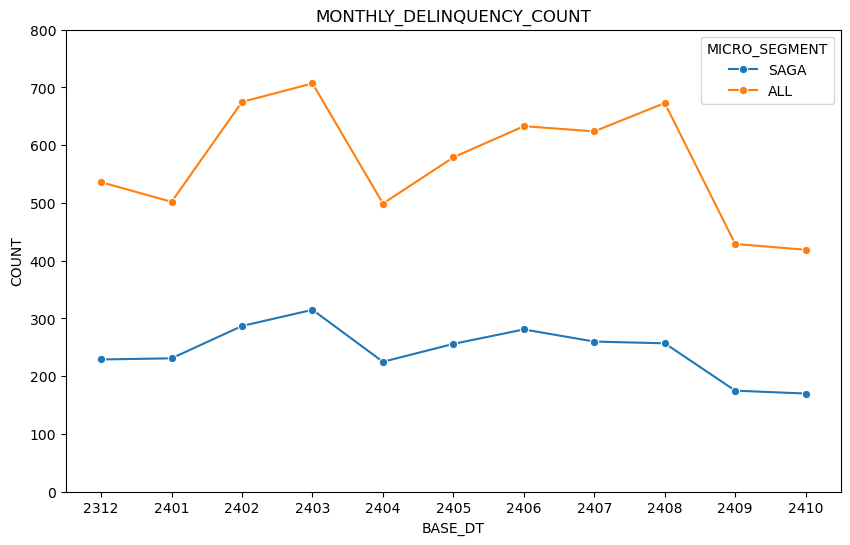

In [ ]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("MONTHLY_DELINQUENCY_COUNT")
plt.xlabel("BASE_DT")
plt.ylim((0,800))
plt.ylabel("COUNT")
sns.lineplot(data=MonthlyGCIFDeliComb, x="BASE_DT", y='GCIF_COUNT', hue='MICRO_SEGMENT', marker="o")

## 3. Distribution

In [ ]:
MLs

,BASE_DT,AGREE_ID,GCIF_NO,CIF_NO,NOTE_NO,PRD_TP,PRD_NM,PRD_SEGMENT,ORG_LMT_AMT,CURR_LMT_AMT,BAL,ORIG_INT_RT,CURR_INT_RT,OTH_CURR_INT_RT,CLCT_RTNG_FCL,ALLOW_PCT,ALLOW_PCT_ADD,RESTRUCT_CD,PASTDUE_SINCE_DT,PASTDUE_DAYS,WRITE_OFF_AMT,WRITE_OFF_DT,WRITE_OFF_YN,CC_STATUS,SEGMENT,CUST_NM,OPEN_DATE,LAST_ACTIVE_DATE,CUST_TP,GENDER_CD,AGE,SAGA_FLAG,EMPLOYMENT_TYPE,CA_BAL,CA_AVG,SA_BAL,SA_AVG,TD_NOA,TD_BAL,TD_AVG,SY_FUNDING_BAL,SY_FUNDING_AVG,FUNDING_NOA,FUNDING_BAL,FUNDING_AVG,NOA_DORMANT,CC_PLAFOND,CC_BAL,PL_PLAFOND,PLOAN_BAL,TR_PLAFOND,TR_BAL,PB_PLAFOND,PB_BAL,PRK_PLAFOND,PRK_BAL,PPB_PLAFOND,PPB_BAL,BG_PLAFOND,BG_BAL,LC_PLAFOND,LC_BAL,SY_LOAN_PLAFOND,SY_LOAN_BAL,KPR_PLAFOND,KPR_BAL,KPM_PLAFOND,KPM_BAL,COLLECT,MF_BAL,BONDS_BAL,TRB,M2U_TRX_TOTAL,M2U_TRXAMT_FIN,CRTRX_MTD,CRTRX_AMT_MTD,DBTRX_MTD,DBTRX_AMT_MTD,DELINQUENT
0,20241031,CP0010014423730000971013,G900439944,1060070000205334,4423730000971013,001,Credit Card,031100,3000000.0,4000000.00,0.0,0.21,0.21,0.21,00001,0.01,0.0,00001,99991231,0,0.0,None,N,PERFORMING,None,"NELLY RUSDIANA, SE",1990-09-29 00:00:00,NaT,INDV,F,61.0,SAGA,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5600000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20241031,CP0010014423730006464013,G800487613,1010011750233507,4423730006464013,001,Credit Card,031100,20000000.0,28000000.00,0.0,0.21,0.21,0.21,00001,0.01,0.0,00001,99991231,0,0.0,None,N,PERFORMING,CFS-RB-5MB,DAVID SANTOLO,2002-06-27 00:00:00,2022-12-12,INDV,M,57.0,SAGA,SELF EMPLOYED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,20000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20241031,CP0010014423730008663018,G901830901,1250622800000065,4423730008663018,001,Credit Card,031100,10860000.0,1086396.00,1086396.0,0.21,0.21,0.21,00001,0.01,0.0,00001,99991231,0,0.0,None,N,PERFORMING,None,ROYKO T G N SUMAKUL,2005-08-22 00:00:00,NaT,INDV,M,47.0,NON-SAGA,OTHERS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10860000.0,1086396.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1086396.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20241031,CP0010014423730017835029,G205325640,1010001100682487,4423730017835029,001,Credit Card,031100,47000000.0,28500000.00,0.0,0.21,0.21,0.21,00001,0.01,0.0,00001,99991231,0,0.0,None,N,PERFORMING,None,LILIAWATI,1995-06-01 00:00:00,NaT,INDV,F,64.0,SAGA,SELF EMPLOYED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20241031,CP0010014423730024353024,G600408520,1040840000273762,4423730024353024,001,Credit Card,031100,4000000.0,44418410.00,0.0,0.21,0.21,0.21,00001,0.01,0.0,00001,99991231,0,0.0,None,N,PERFORMING,None,I TANTIO ATMOKO,1997-05-21 00:00:00,NaT,INDV,M,70.0,SAGA,OTHERS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000000.0,4581590.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4581590.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177445,20231130,CP0010223562851021029004,G509569562,1118880000357972,3562851021029004,001,Credit Card,031100,847500.0,22480700.00,0.0,0.21,0.21,0.21,00001,1.00,0.0,00001,99991231,0,0.0,None,N,PERFORMING,None,None,None,NaT,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2177446,20231130,CP0010024423740355291008,G005611744,1000009990287707,4423

### a. BAL by SAGA_FLAG and CC_STATUS

c:\Users\MR38804\AppData\Local\anaconda3\envs\Py64\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


<Axes: xlabel='SAGA_FLAG', ylabel='BAL'>

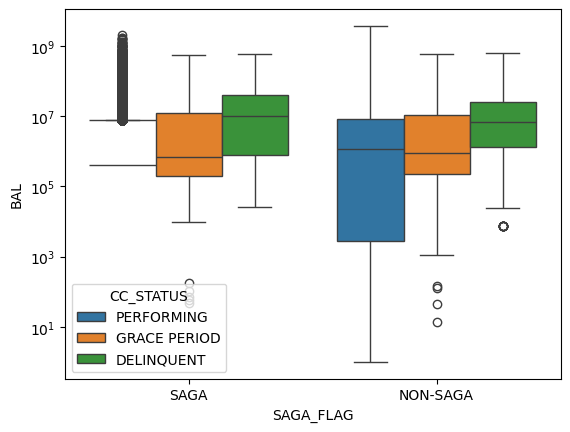

In [ ]:
# create BAL boxplot by SAGA FLAG
sns.boxplot(data=MLs, x="SAGA_FLAG", y="BAL", hue="CC_STATUS", log_scale=True)

### b. LMT by SAGA_FLAG and CC_STATUS

<Axes: xlabel='SAGA_FLAG', ylabel='CURR_LMT_AMT'>

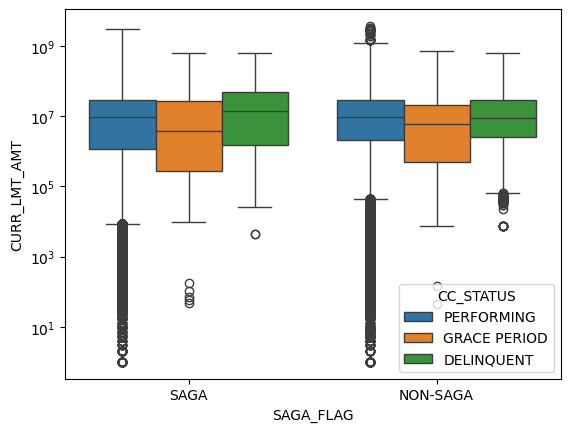

In [ ]:
# create LMT boxplot by SAGA FLAG
sns.boxplot(data=MLs, x="SAGA_FLAG", y="CURR_LMT_AMT", hue="CC_STATUS", log_scale=True)

### c. Monthly Delinquentts by SAGA_FLAG and CC_STATUS

<Axes: xlabel='BASE_DT', ylabel='BAL'>

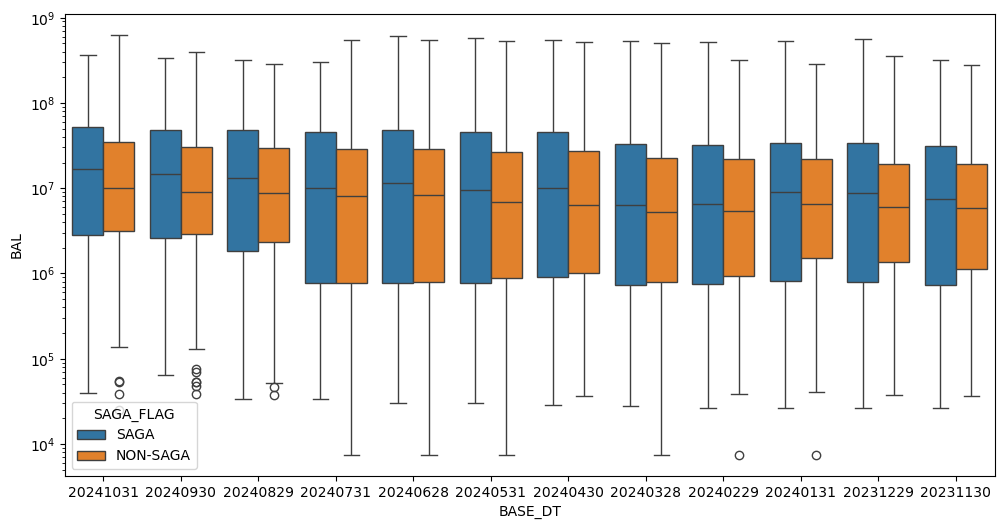

In [ ]:
# create boxplot MONTHLY
plt.figure(figsize=(12,6))
sns.boxplot(data=MLs[MLs['CC_STATUS']=='DELINQUENT'], x="BASE_DT", y="BAL", hue="SAGA_FLAG", log_scale=True)

<Axes: xlabel='BASE_DT', ylabel='CURR_LMT_AMT'>

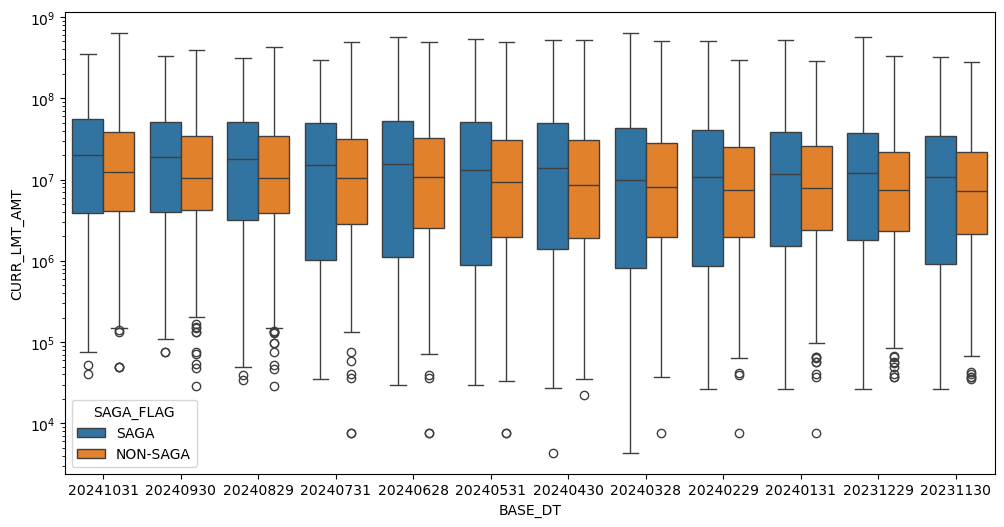

In [ ]:
# create boxplot MONTHLY
plt.figure(figsize=(12,6))
sns.boxplot(data=MLs[MLs['CC_STATUS']=='DELINQUENT'], x="BASE_DT", y="CURR_LMT_AMT", hue="SAGA_FLAG", log_scale=True)

### d. Utilization

In [ ]:
# calculate utilization
MLs['UTIL'] = MLs.apply(lambda x: x['BAL']/x['CURR_LMT_AMT'] if x['CURR_LMT_AMT']>0 else 0, axis=1)

<Axes: xlabel='BASE_DT', ylabel='UTIL'>

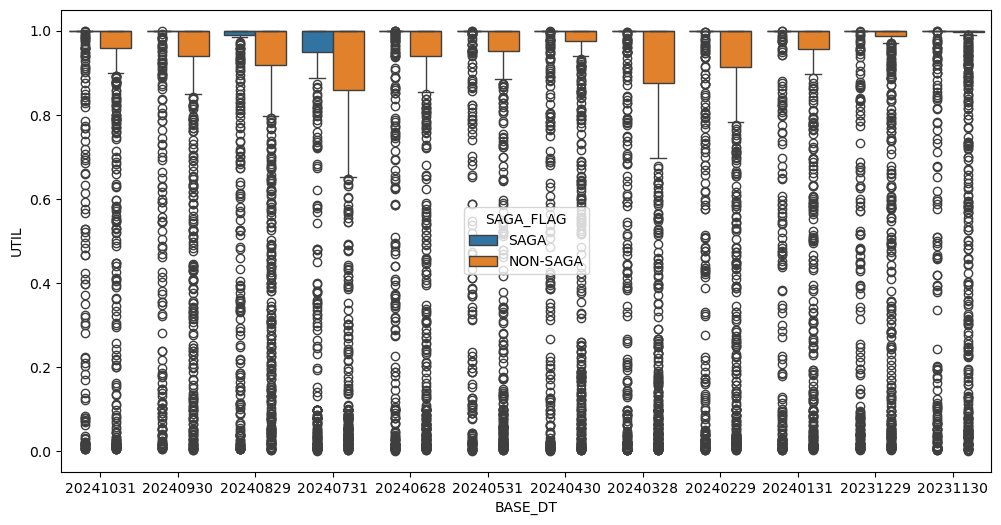

In [ ]:
# create boxplot MONTHLY
plt.figure(figsize=(12,6))
sns.boxplot(data=MLs[(MLs['CC_STATUS']=='DELINQUENT') & (MLs['UTIL']<=1)], x="BASE_DT", y="UTIL", hue="SAGA_FLAG")

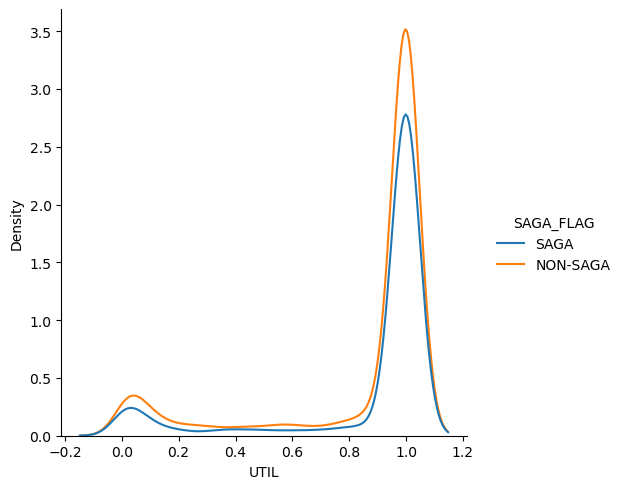

In [ ]:
# plot utilizatiuon kde for delinquents by SAGA_FLAG
sns.displot(MLs[(MLs['CC_STATUS']=='DELINQUENT') & (MLs['UTIL']<=1)], x='UTIL', hue='SAGA_FLAG', kind='kde')

In [ ]:
# # plot utilizatiuon histogram for delinquents by SAGA_FLAG
# sns.displot(MLs[(MLs['CC_STATUS']=='DELINQUENT') & (MLs['UTIL']<=1)], x='UTIL', hue='SAGA_FLAG', binwidth=0.05)

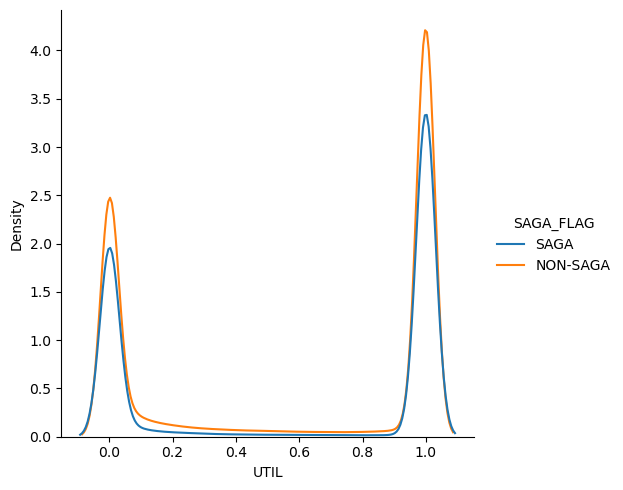

In [ ]:
# plot utilizatiuon kde for performers by SAGA_FLAG
sns.displot(MLs[(MLs['CC_STATUS']=='PERFORMING') & (MLs['UTIL']<=1)], x='UTIL', hue='SAGA_FLAG', kind='kde')

In [ ]:
# # plot utilizatiuon histogram for performers by SAGA_FLAG
# sns.displot(MLs[(MLs['CC_STATUS']=='PERFORMING') & (MLs['UTIL']<=1)], x='UTIL', hue='SAGA_FLAG', binwidth=0.05)

### e. Employment Type

In [ ]:
MLsGCIF

,BASE_DT,GCIF_NO,SUM_LMT,SUM_BAL,NOA,SAGA_FLAG,PASTDUE_DAYS_MAX,CC_STATUS,DELINQUENT
0,20231130,EX0000000009531013,39812500.00,0.0,7,NaN,0,PERFORMING,NaN
1,20231130,EX0000000009531021,12000000.00,0.0,2,NaN,0,PERFORMING,NaN
2,20231130,EX0000000009531039,2250000.00,0.0,2,NaN,0,PERFORMING,NaN
3,20231130,EX0000000009531047,44052764.61,480990.0,11,NaN,0,PERFORMING,NaN
4,20231130,EX0000000009531054,11598367.00,196734.0,6,NaN,0,PERFORMING,NaN
...,...,...,...,...,...,...,...,...,...
1469019,20241031,G910398577,8000000.00,7610999.0,1,NON-SAGA,0,PERFORMING,0.0
1469020,20241031,G910398734,35000000.00,1497748.0,1,NON-SAGA,0,PERFORMING,0.0
1469021,20241031,G910399518,70000000.00,9286706.0,1,NON-SAGA,0,PERFORMING,0.0
1469022,20241031,G910402478,12000000.00,1287038.0,1,NON-SAGA,0,PERFORMING,0.0


In [ ]:
# distinct base_dt emp_type df
distEmp = MLs[['BASE_DT','GCIF_NO','EMPLOYMENT_TYPE']].drop_duplicates()


In [ ]:
# merge employment type
MLsGCIFEmp = MLsGCIF.merge(distEmp, on=['BASE_DT','GCIF_NO'], how='left')

# group based on employment type
EmpGPD = MLsGCIFEmp[['BASE_DT','SUM_LMT','SUM_BAL','NOA',
                  'SAGA_FLAG','CC_STATUS','EMPLOYMENT_TYPE']].groupby(
                      ['BASE_DT','SAGA_FLAG','CC_STATUS','EMPLOYMENT_TYPE']).agg(
                          NOC=('BASE_DT','count'),
                          SUM_LMT=('SUM_LMT','sum'),
                          SUM_BAL=('SUM_BAL','sum'),
                          NOA=('NOA','sum')
                      ).reset_index()

In [ ]:
EmpGPD

,BASE_DT,SAGA_FLAG,CC_STATUS,EMPLOYMENT_TYPE,NOC,SUM_LMT,SUM_BAL,NOA
0,20231130,NON-SAGA,DELINQUENT,EMPLOYED PERMANENT,511,1.019878e+10,9.277205e+09,696
1,20231130,NON-SAGA,DELINQUENT,HOUSEWIFE,10,2.073163e+08,1.796892e+08,11
2,20231130,NON-SAGA,DELINQUENT,OTHERS,392,7.154955e+09,6.655708e+09,518
3,20231130,NON-SAGA,DELINQUENT,PART TIME BASIS,13,2.080907e+08,1.457933e+08,16
4,20231130,NON-SAGA,DELINQUENT,PEMERINTAHAN,6,1.412832e+08,1.270323e+08,6
...,...,...,...,...,...,...,...,...
846,20241031,SAGA,PERFORMING,SELF EMPLOYED,16357,7.994865e+11,2.772891e+11,26571
847,20241031,SAGA,PERFORMING,STUDENT,2,1.264000e+08,0.000000e+00,3
848,20241031,SAGA,PERFORMING,SWASTA,835,3.378628e+10,1.303788e+10,1295
849,20241031,SAGA,PERFORMING,TNI/POLRI,16,7.070617e+08,2.561967e+08,30


In [ ]:
EmpGPD[(EmpGPD['BASE_DT']=='20241031')&(EmpGPD['SAGA_FLAG']=='SAGA')]

,BASE_DT,SAGA_FLAG,CC_STATUS,EMPLOYMENT_TYPE,NOC,SUM_LMT,SUM_BAL,NOA
814,20241031,SAGA,DELINQUENT,EMPLOYED PERMANENT,159,7.756668e+09,7.179983e+09,224
815,20241031,SAGA,DELINQUENT,HOUSEWIFE,15,6.726032e+08,6.277176e+08,20
816,20241031,SAGA,DELINQUENT,OTHERS,252,1.123895e+10,9.975728e+09,368
817,20241031,SAGA,DELINQUENT,PART TIME BASIS,2,5.982950e+07,5.982950e+07,2
818,20241031,SAGA,DELINQUENT,PEMERINTAHAN,7,2.032423e+08,2.038003e+08,10
819,20241031,SAGA,DELINQUENT,PROFESSIONAL,8,4.665816e+08,4.656541e+08,15
820,20241031,SAGA,DELINQUENT,RETIRED,12,8.860568e+08,8.163185e+08,16
821,20241031,SAGA,DELINQUENT,SELF EMPLOYED,196,1.165775e+10,1.056987e+10,305
822,20241031,SAGA,DELINQUENT,STUDENT,1,1.008041e+07,1.008041e+07,2
823,20241031,SAGA,DELINQUENT,SWASTA,18,1.414693e+09,1.213611e+09,32


#### i. All SAGA

In [142]:
# all SAGA employment type
AllSAGAEmp = EmpGPD[
    (EmpGPD['BASE_DT']=='20241031')&(EmpGPD['SAGA_FLAG']=='SAGA')][
        ['EMPLOYMENT_TYPE','NOC','SUM_BAL']].groupby(
            'EMPLOYMENT_TYPE'
        ).agg(
            NOC=('NOC','sum'),
            SUM_BAL=('SUM_BAL','sum')
        ).reset_index()

In [147]:
# Calculate percentage
AllSAGAEmp = AllSAGAEmp.sort_values(['EMPLOYMENT_TYPE'])
AllSAGAEmp['TOTAL_NOC'] = AllSAGAEmp['NOC'].sum()
AllSAGAEmp['TOTAL_BAL'] = AllSAGAEmp['SUM_BAL'].sum()
AllSAGAEmp['NOC_%'] = AllSAGAEmp['NOC']/AllSAGAEmp['TOTAL_NOC']
AllSAGAEmp['SUM_BAL%'] = AllSAGAEmp['SUM_BAL']/AllSAGAEmp['TOTAL_BAL']

In [148]:
AllSAGAEmp

,EMPLOYMENT_TYPE,NOC,SUM_BAL,NOC_%,SUM_BAL%,TOTAL_NOC,TOTAL_BAL
0,EMPLOYED PERMANENT,12355,1.998196e+11,0.264822,0.252053,46654,7.927675e+11
1,HOUSEWIFE,1158,1.465485e+10,0.024821,0.018486,46654,7.927675e+11
2,OTHERS,13646,2.423604e+11,0.292494,0.305714,46654,7.927675e+11
3,PART TIME BASIS,66,7.007563e+08,0.001415,0.000884,46654,7.927675e+11
4,PEMERINTAHAN,325,4.997564e+09,0.006966,0.006304,46654,7.927675e+11
5,PEMUKA AGAMA,41,6.065873e+08,0.000879,0.000765,46654,7.927675e+11
6,PROFESSIONAL,603,1.142345e+10,0.012925,0.014410,46654,7.927675e+11
7,RETIRED,538,6.127319e+09,0.011532,0.007729,46654,7.927675e+11
8,SELF EMPLOYED,16951,2.944951e+11,0.363334,0.371477,46654,7.927675e+11
9,STUDENT,4,9.884559e+07,0.000086,0.000125,46654,7.927675e+11


#### ii. Delinquent SAGA

In [152]:
# delinquent SAGA employment type
DeliSAGAEmp = EmpGPD[
    (EmpGPD['BASE_DT']=='20241031')&(EmpGPD['SAGA_FLAG']=='SAGA')&(MLs['CC_STATUS']=='DELINQUENT')][
        ['EMPLOYMENT_TYPE','NOC','SUM_BAL']].groupby(
            'EMPLOYMENT_TYPE'
        ).agg(
            NOC=('NOC','sum'),
            SUM_BAL=('SUM_BAL','sum')
        ).reset_index()

C:\Users\MR38804\AppData\Local\Temp\ipykernel_15760\337423944.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  DeliSAGAEmp = EmpGPD[


In [154]:
EmpGPD[
    (EmpGPD['BASE_DT']=='20241031')&(EmpGPD['SAGA_FLAG']=='SAGA')&(MLs['CC_STATUS']=='DELINQUENT')][
        ['EMPLOYMENT_TYPE','NOC','SUM_BAL']]

C:\Users\MR38804\AppData\Local\Temp\ipykernel_15760\3987942519.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  EmpGPD[


,EMPLOYMENT_TYPE,NOC,SUM_BAL
834,STUDENT,1,88765178.0


In [153]:
DeliSAGAEmp

,EMPLOYMENT_TYPE,NOC,SUM_BAL
0,STUDENT,1,88765178.0


In [150]:
# Calculate percentage
DeliSAGAEmp = DeliSAGAEmp.sort_values(['EMPLOYMENT_TYPE'])
DeliSAGAEmp['TOTAL_NOC'] = DeliSAGAEmp['NOC'].sum()
DeliSAGAEmp['TOTAL_BAL'] = DeliSAGAEmp['SUM_BAL'].sum()
DeliSAGAEmp['NOC_%'] = DeliSAGAEmp['NOC']/DeliSAGAEmp['TOTAL_NOC']
DeliSAGAEmp['SUM_BAL%'] = DeliSAGAEmp['SUM_BAL']/DeliSAGAEmp['TOTAL_BAL']

In [151]:
DeliSAGAEmp

,EMPLOYMENT_TYPE,NOC,SUM_BAL,TOTAL_NOC,TOTAL_BAL,NOC_%,SUM_BAL%
0,STUDENT,1,88765178.0,1,88765178.0,1.0,1.0


In [145]:
MLs[(MLs['SAGA_FLAG']=='SAGA') & (MLs['BASE_DT']=='20241031') & (MLs['CC_STATUS']=='DELINQUENT')][['EMPLOYMENT_TYPE']].value_counts()

EMPLOYMENT_TYPE   
OTHERS                284
SELF EMPLOYED         234
EMPLOYED PERMANENT    190
SWASTA                 23
HOUSEWIFE              17
RETIRED                12
PROFESSIONAL           10
PEMERINTAHAN            7
PART TIME BASIS         2
STUDENT                 1
TNI/POLRI               1
UNEMPLOYED              1
Name: count, dtype: int64

In [143]:
MLs[(MLs['SAGA_FLAG']=='NON-SAGA')& (MLs['BASE_DT']=='20241031')][['EMPLOYMENT_TYPE']].value_counts()

EMPLOYMENT_TYPE   
EMPLOYED PERMANENT    44458
SELF EMPLOYED         33201
OTHERS                17200
SWASTA                 2381
HOUSEWIFE              1127
PROFESSIONAL            952
PEMERINTAHAN            539
PART TIME BASIS         436
STUDENT                 187
UNEMPLOYED               44
PEMUKA AGAMA             23
TNI/POLRI                22
RETIRED                  18
Name: count, dtype: int64

1. Distribusi umur new delinquent SAGA
2. Cek NA berapa OS nya dibanding semua